Circular buffer

In [23]:
import collections
buf = collections.deque(maxlen=5)
buf

deque([])

we have a buffer consisting of 6 images

In [154]:
arr = [i+1 for i in range(6) ]
arr

[1, 2, 3, 4, 5, 6]

we update the buffer with the 7th image (our counter is at 6)

In [155]:
ctr = 6
arr[ctr % len(arr)] = 7
arr

[7, 2, 3, 4, 5, 6]

i want to get the last 4 items

In [160]:
print arr[ctr % len(arr)], arr[ (ctr-1) % len(arr) ], arr[ (ctr-2) % len(arr) ], arr[ (ctr-3) % len(arr) ]

7 6 5 4


In [165]:
#we get another image and add it
ctr += 1
arr[ctr % len(arr)] = 8
arr

[7, 8, 3, 4, 5, 6]

In [167]:
# get the last 4 items
print arr[ctr % len(arr)], arr[ (ctr-1) % len(arr) ], arr[ (ctr-2) % len(arr) ], arr[ (ctr-3) % len(arr) ]

8 7 6 5


In [170]:
ctr % len(arr)

1

question: what if ctr overflows?? should we just set it to 0 provided when ctr % len(arr) == 0 as well??

----------

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
import gym
env = gym.make('Pong-v0')
print(env.action_space)
print(env.observation_space)

[2017-03-29 11:48:34,452] Making new env: Pong-v0


Discrete(6)
Box(210, 160, 3)


In [5]:
env.reset()

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ..., 
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       [[109, 118,  43],
        [109, 118,  43],
        [109, 118,  43],
        ..., 
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       [[109, 118,  43],
        [109, 118,  43],
        [109, 118,  43],
        ..., 
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       ..., 
       [[ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24],
        ..., 
        [ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24]],

       [[ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24],
        ..., 
        [ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24]],

       [[ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24],
        ..., 
        [ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,

In [6]:
obs, reward, done, info = env.step(0)

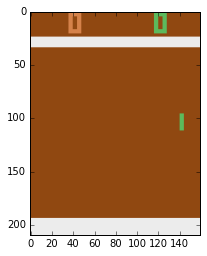

In [7]:
plt.imshow(obs)

In [8]:
from skimage import img_as_ubyte, img_as_float
from skimage.color import rgb2gray

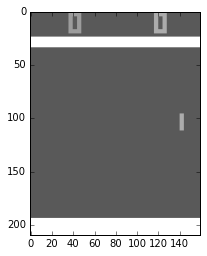

In [13]:
plt.imshow(img_as_float(img_as_ubyte(rgb2gray(obs))),cmap="gray")

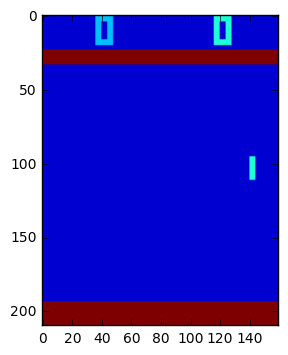

In [6]:
img = np.transpose(obs, (2, 0, 1))
plt.imshow(img[2])

In [7]:
np.mean(img, axis=0, keepdims=True).shape, img.shape

((1, 210, 160), (3, 210, 160))

In [8]:
img_batch = np.asarray([img,img,img,img,img])
img_batch = img_batch.astype("float32")
img_batch.shape

(5, 3, 210, 160)

In [9]:
import os
os.environ["HDF5_DISABLE_VERSION_CHECK"] = "1"
from keras.preprocessing.image import ImageDataGenerator

Using Theano backend.


In [10]:
imgen = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)

In [11]:
for x, _ in imgen.flow(np.asarray([img]), np.asarray([0])):
    print x.shape
    break

(1, 3, 210, 160)


Samplewise centering with Keras data augmentor: for an image of dim (b, f, h, w), the mean is (b, 1, h, w), i.e. we stdize over the feature map axis. For feature-wise, we also do the mean over bs axis.

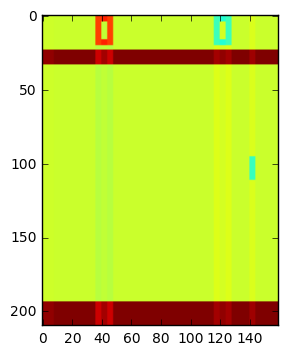

In [12]:
plt.imshow( imgen.standardize(img.astype("float32")[0]) )

The technique I have always used in the past (which I'm not sure is standard practice): the mean is (f,1), so each feature map gets a mean over all the pixels

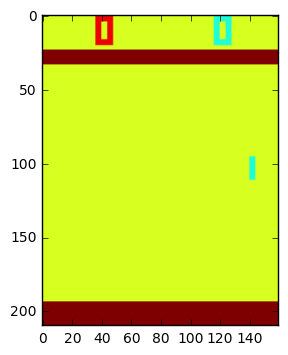

In [13]:
plt.imshow( (img[0] - np.mean(img[0])) / np.std(img[0]) )

----------

In [14]:
import theano
from theano import tensor as T
import lasagne
from lasagne.layers import *
from lasagne.objectives import *
from lasagne.nonlinearities import *

In [15]:
def q_net(env):
    height, width, nchannels = env.observation_space.shape
    l_in = InputLayer((None, nchannels, height, width))
    l_conv = Conv2DLayer(l_in, num_filters=32, filter_size=3, stride=2)
    l_conv2 = Conv2DLayer(l_conv, num_filters=64, filter_size=3, stride=2)
    l_conv3 = Conv2DLayer(l_conv2, num_filters=96, filter_size=3, stride=2)
    l_conv4 = Conv2DLayer(l_conv3, num_filters=128, filter_size=3, stride=2)
    l_dense = DenseLayer(l_conv4, num_units=env.action_space.n)
    return l_dense

In [16]:
X = T.tensor4('X')
y = T.fmatrix('y') # this is a row column
action_mask = T.fmatrix('action_mask')

In [17]:
l_out = q_net(env)
print count_params(l_out)
for layer in get_all_layers(l_out):
    print layer, layer.output_shape

268454
<lasagne.layers.input.InputLayer object at 0x11ddd5e10> (None, 3, 210, 160)
<lasagne.layers.conv.Conv2DLayer object at 0x11ddd5e90> (None, 32, 104, 79)
<lasagne.layers.conv.Conv2DLayer object at 0x11dd83350> (None, 64, 51, 39)
<lasagne.layers.conv.Conv2DLayer object at 0x11dd83650> (None, 96, 25, 19)
<lasagne.layers.conv.Conv2DLayer object at 0x11dd83950> (None, 128, 12, 9)
<lasagne.layers.dense.DenseLayer object at 0x11dd83c50> (None, 6)


In [18]:
q_out = get_output(l_out, X)
q_out

Elemwise{mul,no_inplace}.0

Let's do an example y matrix.

In [19]:
ytest = np.asarray([[1],[2],[1],[3.5],[4],[1.]])
ytest

array([[ 1. ],
       [ 2. ],
       [ 1. ],
       [ 3.5],
       [ 4. ],
       [ 1. ]])

We now need a mask for the Q. Suppose that for the random minibatch, for the first element we selected the first action, then for the second element we selected the second action, etc....

In [20]:
masktest = np.eye(6)
masktest

array([[ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.]])

In [21]:
loss = y - (action_mask*q_out).sum(axis=1)
loss

Elemwise{sub,no_inplace}.0

-------------

Ok, write code to buffer images

In [38]:
from skimage.color import rgb2gray

In [241]:
env = gym.make('Pong-v0')
buf_maxlen = 4
buf = []
buf_idx = []
experience = []
for t in range(10000):
    # if the buffer is not at max length, do random actions
    # to fill it up
    if len(buf) != buf_maxlen:
        a_t = env.action_space.sample()
        x, _, _, _ = env.step(a_t)
        buf.append(rgb2gray(x))
        buf_idx.append(t)
    else:
        # phi_t is going to be the 4 most recent frames
        phi_t = np.asarray([
            buf[(t-1-3)%len(buf)], 
            buf[(t-1-2)%len(buf)], 
            buf[(t-1-1)%len(buf)], 
            buf[(t-1-0)%len(buf)]
        ]).astype("float32")
        debug_t = [buf_idx[(t-1-3)%len(buf_idx)], 
                   buf_idx[(t-1-2)%len(buf_idx)], 
                   buf_idx[(t-1-1)%len(buf_idx)], 
                   buf_idx[(t-1-0)%len(buf_idx)]]
        # with probability eps, select a random action
        a_t = env.action_space.sample()
        # execute action a_t in emulator and observe reward r_t and image x_t+1
        x_t1, r_t, is_done, info = env.step(a_t)
        # insert x_t+1 into the buffer, then grab the next
        # 4 most recent frames
        if not is_done:
            buf[ (t) % len(buf) ] = rgb2gray(x_t1)
            buf_idx[ (t) % len(buf) ] = t
            phi_t1 = np.asarray([
                buf[(t-3)%len(buf)], 
                buf[(t-2)%len(buf)], 
                buf[(t-1)%len(buf)], 
                buf[(t-0)%len(buf)]
            ]).astype("float32")
            debug_t1 = [buf_idx[(t-3)%len(buf_idx)], 
                       buf_idx[(t-2)%len(buf_idx)], 
                       buf_idx[(t-1)%len(buf_idx)], 
                       buf_idx[(t-0)%len(buf_idx)]]
        else:
            phi_t1 = None
        #print debug_t, debug_t1
        # add this tuple to the experience buffer
        experience.append( (phi_t, a_t, r_t, phi_t1) )
        # sample from random experience from the buffer
        some_tp = experience[ np.random.randint(0, len(experience)) ]
        if is_done:
            ytarget = some_tp[2]
        else:
            ytarget = some_tp[2] + gamma*1 # todo: add Q
        
        
        break

[2017-03-16 11:56:48,248] Making new env: Pong-v0


(array([[[ 0.        ,  0.        ,  0.        , ...,  0.32680196,
          0.32680196,  0.32680196],
        [ 0.32680196,  0.32680196,  0.32680196, ...,  0.32680196,
          0.32680196,  0.32680196],
        [ 0.32680196,  0.32680196,  0.32680196, ...,  0.32680196,
          0.32680196,  0.32680196],
        ..., 
        [ 0.9254902 ,  0.9254902 ,  0.9254902 , ...,  0.9254902 ,
          0.9254902 ,  0.9254902 ],
        [ 0.9254902 ,  0.9254902 ,  0.9254902 , ...,  0.9254902 ,
          0.9254902 ,  0.9254902 ],
        [ 0.9254902 ,  0.9254902 ,  0.9254902 , ...,  0.9254902 ,
          0.9254902 ,  0.9254902 ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.32680196,
          0.32680196,  0.32680196],
        [ 0.32680196,  0.32680196,  0.32680196, ...,  0.32680196,
          0.32680196,  0.32680196],
        [ 0.32680196,  0.32680196,  0.32680196, ...,  0.32680196,
          0.32680196,  0.32680196],
        ..., 
        [ 0.9254902 ,  0.9254902 ,  0.9254902 , ...

----------

In [225]:
def test_cycle(buf, maxlen):
    for t in range(0, 10):
        # fill up the buffer if it ain't full
        if len(buf) != maxlen:
            buf.append(t)
            print buf
        else:
            #print buf
            #print t
            s_t = (
                buf[(t-1-3)%len(buf)], 
                buf[(t-1-2)%len(buf)], 
                buf[(t-1-1)%len(buf)], 
                buf[(t-1-0)%len(buf)]
            )
            buf[ (t) % len(buf) ] = t
            #print buf
            s_t1 = (
                buf[(t-3)%len(buf)], 
                buf[(t-2)%len(buf)], 
                buf[(t-1)%len(buf)], 
                buf[(t-0)%len(buf)]
            )
            print s_t, s_t1


In [226]:
test_cycle([], 4)

[0]
[0, 1]
[0, 1, 2]
[0, 1, 2, 3]
(0, 1, 2, 3) (1, 2, 3, 4)
(1, 2, 3, 4) (2, 3, 4, 5)
(2, 3, 4, 5) (3, 4, 5, 6)
(3, 4, 5, 6) (4, 5, 6, 7)
(4, 5, 6, 7) (5, 6, 7, 8)
(5, 6, 7, 8) (6, 7, 8, 9)
